# YOLO: You Only Look Once

In class, you have learnt about how convolutional neural networks (CNNs) are commonly used to analyze visual imagery. CNNs are known to be shift-invariance based on the weight-sharing architecture of convolutional kernels which slide along input features and provide translational equivariant responses. In previous assignments, we have used CNNs for **object classification** to identify the class of one object in a simple image. In this notebook, we will explore how CNNs can be used for **object detection** in the case where multiple relevant objects are present in a single image. 

Prior work on object detection repurposes classifiers on sliding windows to perform detection, which is slow and expensive for real-time inference demanding detectors for 45 frames per second. The paper ["You Only Look Once: Unified, Real-Time Object Detection"](https://arxiv.org/abs/1506.02640) explores an extremely fast method YOLOv1 which elegantly frames object detection as a regression problem. In this notebook, we will investigate a simple version of YOLO using a synthetic dataset of polygons. 

In [2]:
!pip install torchprofile 1>/dev/null


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
!git clone https://github.com/eric-li-2/CS182-Final-Project-YOLO.git
%cd CS182-Final-Project-YOLO

Cloning into 'CS182-Final-Project-YOLO'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 74 (delta 38), reused 54 (delta 24), pack-reused 0
Receiving objects: 100% (74/74), 26.73 KiB | 1.57 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/home/nickatomlin/jyue/CS182-Final-Project-YOLO


In [4]:
import torch
import os
import sys
import torchvision
from torchvision.io import write_png
from tqdm import tqdm 
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

from createDatasets import generateCircleSquaresImage, generateSingleCircleSquaresImage
from datasets import CircleSquareYOLODataset, CircleSquareClassifierDataset
from model import Yolov1, BaselineClassifier, BaselineObjectDetector
from loss import YoloLoss
from utils import (
    cellboxes_to_boxes,
    convert_cellboxes,
    non_max_suppression,
    # mean_average_precision,
    plot_image,
    save_checkpoint,
    load_checkpoint,
    showData,
)
from train import train_fn, testModel, clf_accuracy, testBaseline

DEVICE = "cuda" if torch.cuda.is_available else "cpu"
# DEVICE = 'cpu'

First, let's download our data. We have provided a synthetic dataset generator that produces images each with multiple squares and circles. This toy dataset allows us experiment with multi-target object detection with fast training times.

In [5]:
# Download synthetic dataset of multiple circles and squares in each image
def download_multiobj_dataset():
    overwrite = True
    img_root = os.path.join(".", "data", "img") 
    annotations_root = os.path.join(".", "data", "annotations")
    try:
        os.makedirs(img_root)
        os.makedirs(annotations_root)
    except FileExistsError:
        print("Data files already exist")
        if not overwrite:
            sys.exit("Overwite set to false, Set overwite to true or delete data directory")
        print("Overwritting existing circle data files")

    num_images = 500
    height = 448
    width = 448

    for i in tqdm(range(num_images)):
        img, labels = generateCircleSquaresImage(height, width, 5)
        img_path = os.path.join(img_root, f"circle_{i}.png")
        label_path = os.path.join(annotations_root,  f"labels_{i}.pt")
        write_png(img, img_path)
        torch.save(labels, label_path)

def download_clf_dataset():
    overwrite = True
    img_root = os.path.join(".", "clf_data", "img") 
    annotations_root = os.path.join(".", "clf_data", "annotations")
    try:
        os.makedirs(img_root)
        os.makedirs(annotations_root)
    except FileExistsError:
        print("Data files already exist")
        if not overwrite:
            sys.exit("Overwite set to false, Set overwite to true or delete data directory")
        print("Overwritting existing circle data files")

    num_images = 400
    height = 256
    width = 256

    for i in tqdm(range(num_images)):
        img, labels = generateSingleCircleSquaresImage(height, width)
        img_path = os.path.join(img_root, f"circle_{i}.png")
        label_path = os.path.join(annotations_root,  f"labels_{i}.pt")
        write_png(img, img_path)
        torch.save(labels, label_path)

print("Downloading multi-object synthetic dataset for object detectors...")
download_multiobj_dataset()

print("Downloading single-object synthetic dataset for classifier...")
download_clf_dataset()

# Initialize datasets and data loaders
BATCH_SIZE = 8
data_dir = os.path.join('.', 'data')
train_dataset = CircleSquareYOLODataset(data_dir)
test_dataset = CircleSquareYOLODataset(None) # generate images during runtime
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

clf_data_dir = os.path.join('.', 'clf_data')
clf_train_dataset = CircleSquareClassifierDataset(clf_data_dir)
clf_test_dataset = CircleSquareClassifierDataset(None) # generate images during runtime
clf_train_loader = DataLoader(
    dataset=clf_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
clf_test_loader = DataLoader(
    dataset=clf_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:53<00:00,  2.88it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 54.55it/s]


In [6]:
# Preview synthetic data
def previewDataset(dataloader, title):
    x_preview, _  = next(iter(dataloader))
    grid = torchvision.utils.make_grid(x_preview, nrow=x_preview.shape[0]).permute(1,2,0)
    plt.figure(figsize=[20, 20])
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.show()

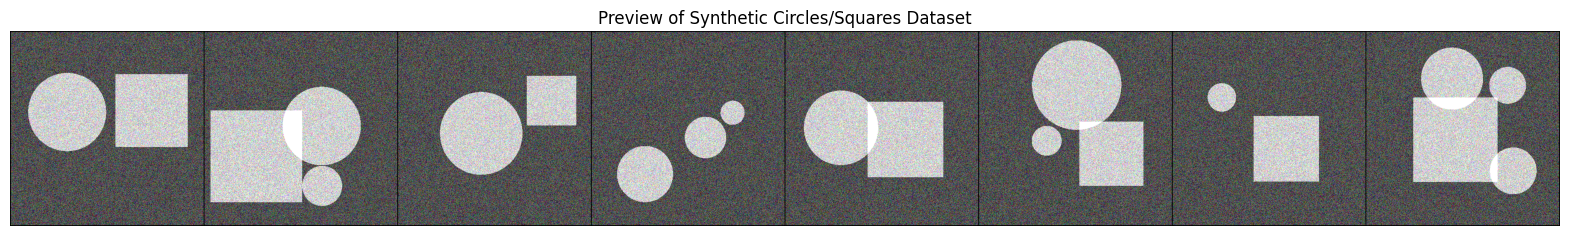

In [7]:
previewDataset(test_loader, "Preview of Synthetic Circles/Squares Dataset")

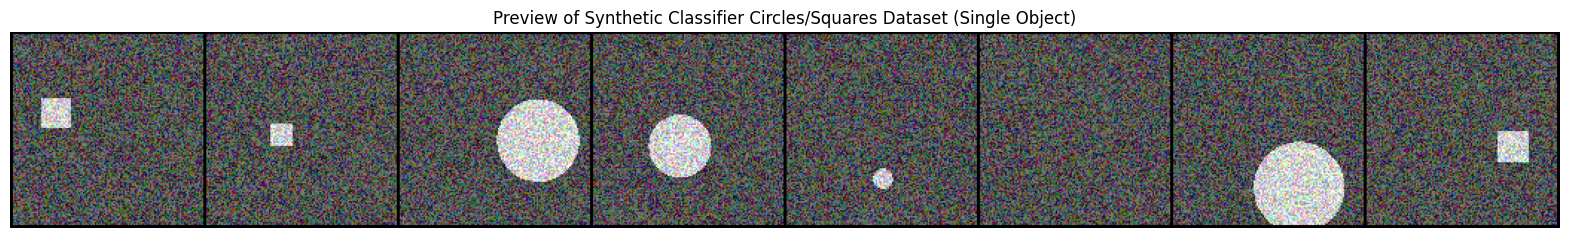

In [8]:
previewDataset(clf_test_loader, "Preview of Synthetic Classifier Circles/Squares Dataset (Single Object)")

## Baseline: Sliding Window Detector

Before YOLO, object detectors were created by repurposing image classifiers to perform localization and detection either by sliding window or regional proposals (i.e. R-CNN). The gif below illustrates the sliding window approach. As you can imagine, this can be quite expensive since the object detector may be redundantly operating on the same pixels many times and each local inference does not leverage the richer contextual information of the entire image.

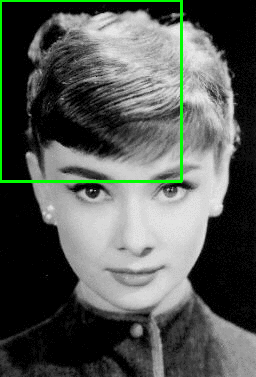

Image Source: [Sliding Windows for Object Detection with Python and OpenCV](https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/)

Let's implement a baseline model that uses a standard image classifier sliding over the input image to perform object detection! We recommending using GPU for training (in Colab go to Runtime -> Change runtime type).

In [ ]:
# Hyperparameters
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0
EPOCHS = 5
LOAD_MODEL = True
LOAD_MODEL_FILE = "pretrained_clf.pth.tar"

# Train standard image classifier
baseline_clf = BaselineClassifier().to(DEVICE)
optimizer = optim.Adam(
    baseline_clf.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Load pretrained weights
if LOAD_MODEL:
    print("Loading pre-trained model...")
    if os.path.exists(LOAD_MODEL_FILE):
        checkpoint = torch.load(LOAD_MODEL_FILE)
        load_checkpoint(checkpoint, baseline_clf, optimizer)
    else:
        print(f"File {LOAD_MODEL_FILE} not found. Exiting")
# Otherwise train the baseline model
else:
    print("Training model...")
    for epoch in range(EPOCHS):
        train_fn(clf_train_loader, baseline_clf, optimizer, loss_fn, DEVICE)
    print("Computing accuracy of baseline classifier...")
    clf_accuracy(test_loader, baseline_clf)
    checkpoint = {
        "state_dict": baseline_clf.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    print("Saving model...")
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

Verify that the accuracy of our classifier should be above 80%. Now, let's implement a sliding window object detector using our high accuracy classifier. **Complete the implementation in the `forward` method of `BaselineObjectDetector` in `model.py`.** 

Now, let's visualize the object detection performance by our baseline object detector. 

In [ ]:
# Visualize outputs
baseline_model = BaselineObjectDetector(baseline_clf)
testBaseline(baseline_model)

Notice that there was a multi-step process in the creation of this object detection pipeline: (1) we had to train a classifier trained on a separate dataset with only single images and (2) we had to build another object detector that slides the classifier across the image. Later, we will compare our sliding window baseline with YOLO by MACs (Multiply–Accumulate), a measure of computational cost.

## Introducing YOLO (You Only Look Once)

In the spirit of improving inference speed with high sensitivity, YOLO is the first of its kind to formulate object detection as a regression problem to spatially separated bounding boxes and associated class probabilities. The entire multi-object detection pipeline is a single neural network which can be optimized end-to-end directly on detection performance. Thus, YOLO aims to eliminate the need for slow complex image detection pipelines, allowing it to support real-time inference and high FPS video streams. Further, unlike sliding window or regional proposal methods, YOLO predicts using the entire image so it leverages richer contextual information for better performance. 

As depicted by the figure from the paper below, YOLO is designed to unify two components of image detection: bounding box prediction and object class prediction. To accomplish this, YOLO divides the image into an $S \times S$ grid, where each grid cell predicts $B$ bounding boxes with corresponding confidence scores and $C$ conditional class probabilities. More specifically each bounding box prediction is a 5-tuple $(x,y,w,h,\text{confidence})$, where the $w \times h$ bounding box is centered at $(x,y)$. 


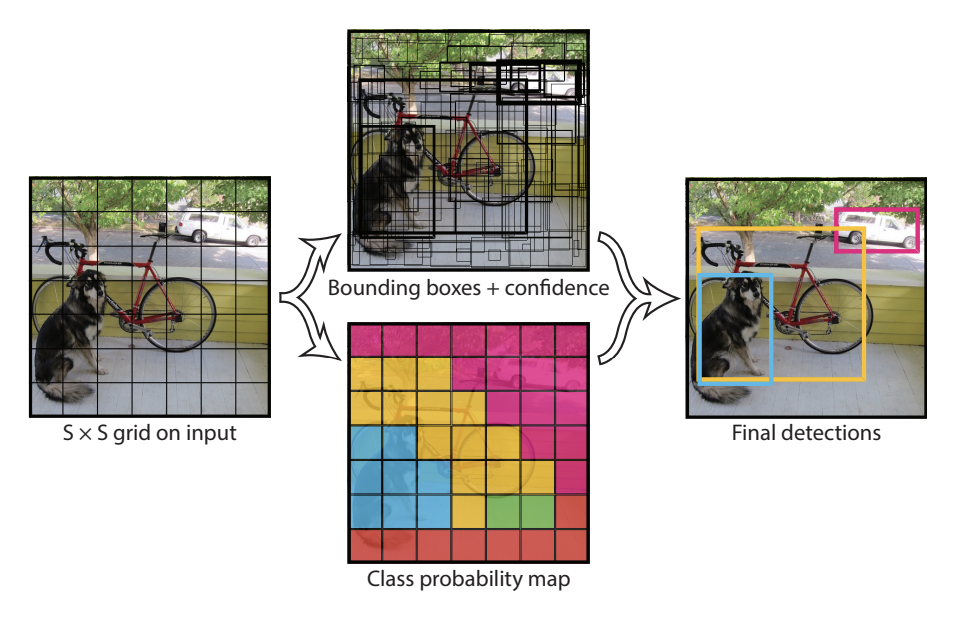

Image Source: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640)

Complete the YOLO architecture by filling out the `_create_fcs` method in the `Yolov1` class found in in `model.py`. Also complete the last part of the `forward` method in the `YoloLoss` class found in `loss.py`. Then, run the following cell to train the model!

In [9]:
# Hyperparameters 
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0
EPOCHS = 10
LOAD_MODEL = False
LOAD_MODEL_FILE = "pretrained.pth.tar"

# Model definitions
model = Yolov1(S=7, B=2, C=2).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss(S=7, B=2, C=2, lambda_noobj=0.5, lambda_coord=5)

# Train or load model
if LOAD_MODEL:
    print("Loading pre-trained model...")
    if os.path.exists(LOAD_MODEL_FILE):
        checkpoint = torch.load(LOAD_MODEL_FILE)
        load_checkpoint(checkpoint, model, optimizer)
    else:
        sys.exit(f"File {LOAD_MODEL_FILE} not found. Exiting")
else:
    print("Training model...")
    for epoch in range(EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
    checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
    print("Saving model...")
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

Training model...


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.16it/s, loss=53.2]


Mean loss was 82.43295509584489


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s, loss=48.4]


Mean loss was 45.496093873054754


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.91it/s, loss=38]


Mean loss was 38.40654846929735


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.96it/s, loss=25.8]


Mean loss was 33.8246739602858


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.06it/s, loss=32.6]


Mean loss was 31.002386677649714


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.83it/s, loss=27.1]


Mean loss was 28.30199675406179


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.73it/s, loss=24.2]


Mean loss was 25.5809815929782


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.04it/s, loss=19.5]


Mean loss was 21.972951765983336


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.09it/s, loss=24.9]


Mean loss was 19.53503870194958


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.09it/s, loss=17.5]


Mean loss was 18.95765196892523
Saving model...
=> Saving checkpoint


Test your model by visualizing some examples!

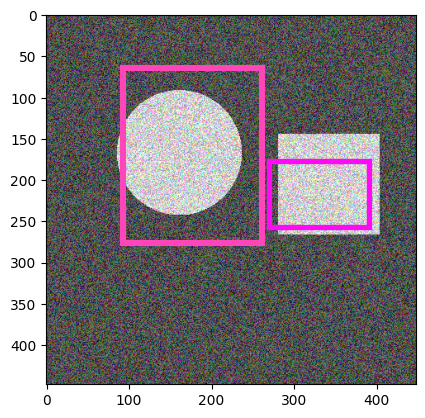

In [10]:
testModel(test_loader, model, DEVICE)

In [11]:
# Hyperparameters 
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0
EPOCHS = 10
LOAD_MODEL = False
LOAD_MODEL_FILE = "noobj0.pth.tar"

# Model definitions
model = Yolov1(S=7, B=2, C=2, ).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss(S=7, B=2, C=2, lambda_noobj=0, lambda_coord=5)

# Train or load model
if LOAD_MODEL:
    print("Loading pre-trained model...")
    if os.path.exists(LOAD_MODEL_FILE):
        checkpoint = torch.load(LOAD_MODEL_FILE)
        load_checkpoint(checkpoint, model, optimizer)
    else:
        sys.exit(f"File {LOAD_MODEL_FILE} not found. Exiting")
else:
    print("Training model...")
    for epoch in range(EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
    checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
    print("Saving model...")
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

Training model...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s, loss=58]


Mean loss was 62.61643255910566


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.94it/s, loss=33.1]


Mean loss was 32.50669313246204


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s, loss=21.7]


Mean loss was 24.83188513786562


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.09it/s, loss=20.6]


Mean loss was 23.018457597301854


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s, loss=14.7]


Mean loss was 21.339683025114


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.86it/s, loss=18.1]


Mean loss was 19.041666538484634


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s, loss=11.2]


Mean loss was 17.93045925324963


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s, loss=15.2]


Mean loss was 17.08659315109253


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.98it/s, loss=14.8]


Mean loss was 14.205146251186248


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.93it/s, loss=11.8]


Mean loss was 12.906718807835732
Saving model...
=> Saving checkpoint


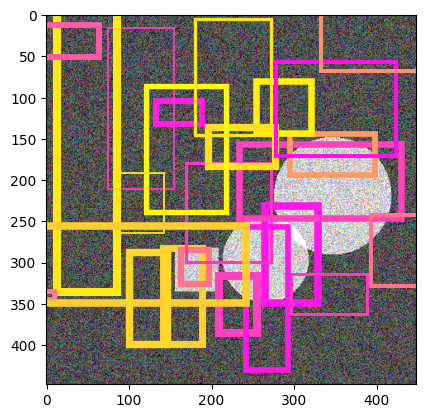

In [12]:
testModel(test_loader, model, DEVICE)

In [13]:
# Hyperparameters 
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0
EPOCHS = 10
LOAD_MODEL = False
LOAD_MODEL_FILE = "coord0.pth.tar"

# Model definitions
model = Yolov1(S=7, B=2, C=2, ).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss(S=7, B=2, C=2, lambda_noobj=0.5, lambda_coord=0)

# Train or load model
if LOAD_MODEL:
    print("Loading pre-trained model...")
    if os.path.exists(LOAD_MODEL_FILE):
        checkpoint = torch.load(LOAD_MODEL_FILE)
        load_checkpoint(checkpoint, model, optimizer)
    else:
        sys.exit(f"File {LOAD_MODEL_FILE} not found. Exiting")
else:
    print("Training model...")
    for epoch in range(EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
    checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
    print("Saving model...")
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

Training model...


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.05it/s, loss=26.7]


Mean loss was 34.770674920851185


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s, loss=19.7]


Mean loss was 22.438822500167355


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s, loss=17.3]


Mean loss was 15.669074658424623


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.81it/s, loss=11.2]


Mean loss was 11.898864361547655


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.94it/s, loss=10.7]


Mean loss was 9.70428208381899


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.01it/s, loss=6.98]


Mean loss was 8.52262044722034


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.85it/s, loss=6.75]


Mean loss was 7.263840113916705


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s, loss=5.25]


Mean loss was 6.375030117650186


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.10it/s, loss=5.35]


Mean loss was 5.452864631529777


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.91it/s, loss=4.56]


Mean loss was 4.597025771294871
Saving model...
=> Saving checkpoint


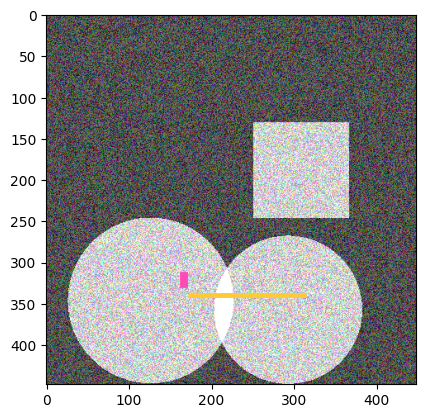

In [14]:
testModel(test_loader, model, DEVICE)